In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
import cv2
import os


In [6]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/5_train.zip', 'r') as zip_ref:
    zip_ref.extractall('content/images8')


In [11]:
files_list = os.listdir('/content/content/images8/train')
num_files = len(files_list)
print(num_files)

25000


In [15]:
import os, shutil, pathlib

org_dir = pathlib.Path(r'/content/content/images8/train')
dst_dir = pathlib.Path(r'/content/my_images')


In [17]:
def make_subset(subset_name, start_index, end_index):
  for category in ('cat', 'dog'):
    dir = dst_dir / subset_name / category
    os.makedirs(dir, exist_ok= True)
    fnames = [f'{category}.{i}.jpg' for i in range(start_index, end_index)]

    for fname in fnames:
      shutil.copyfile(src=org_dir / fname, dst=dir /fname)

make_subset('train', start_index=0, end_index = 5000)
make_subset('validation', start_index = 5000, end_index = 5500)
make_subset('test', start_index= 5500, end_index = 10000)

In [18]:
ca = os.listdir(r'/content/my_images/train/cat')

array([[[224, 225, 220],
        [223, 224, 219],
        [223, 224, 219],
        ...,
        [245, 242, 249],
        [245, 242, 249],
        [245, 242, 249]],

       [[222, 223, 218],
        [222, 223, 218],
        [223, 224, 219],
        ...,
        [246, 245, 251],
        [247, 244, 251],
        [247, 244, 251]],

       [[220, 221, 216],
        [221, 222, 217],
        [221, 222, 217],
        ...,
        [247, 246, 252],
        [248, 247, 253],
        [248, 247, 253]],

       ...,

       [[214, 214, 224],
        [214, 217, 224],
        [211, 214, 219],
        ...,
        [217, 212, 209],
        [217, 211, 211],
        [217, 211, 211]],

       [[211, 215, 224],
        [213, 218, 224],
        [210, 215, 221],
        ...,
        [217, 212, 209],
        [217, 211, 211],
        [217, 211, 211]],

       [[211, 215, 224],
        [213, 218, 224],
        [210, 215, 221],
        ...,
        [217, 212, 209],
        [217, 211, 211],
        [217, 211, 211]]], dtype=uint8)
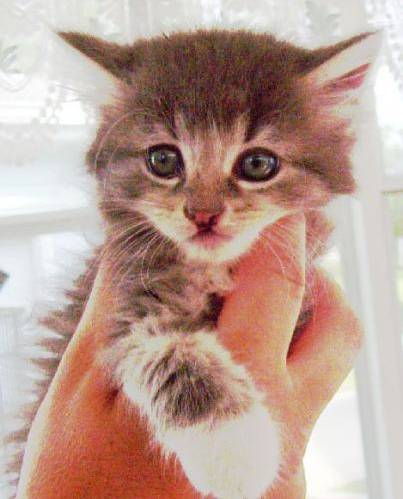

In [24]:
plt.imread(r'/content/my_images/train/cat/cat.100.jpg')

In [20]:
os.path.join('/content/my_images/train','cat')

'/content/my_images/train/cat'

In [33]:
import cv2
labels = ['cat', 'dog']

def get_data(data_dir):
  data = []
  for label in labels:
    path=os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img)) [...,::-1]
        resized_arr = cv2.resize(img_arr, (100,100))
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data, dtype=object)

In [34]:
train = get_data(r'/content/my_images/train')
test = get_data(r'/content/my_images/test')
val = get_data(r'/content/my_images/validation')

In [35]:
print(len(train))
print(len(val))
print(train.shape)
print(val.shape)

10000
1000
(10000, 2)
(1000, 2)


In [36]:
x_train = []
y_train = []

x_val = []
y_val = []

for feature, label in train:
  x_train.append(np.array(feature))
  y_train.append(int(label))

for feature, label in val:
  x_val.append(np.array(feature))
  y_val.append(int(label))

x_train = np.array(x_train).astype('float32')/255
x_val = np.array(x_val).astype('float32')/255


In [37]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range = 30,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    vertical_flip=True)

datagen.fit(x_train)



In [38]:
x_train.shape

(10000, 100, 100, 3)

In [39]:
model = Sequential()
model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,139,649 (19.61 MB)

 Trainable params: 5,139,649 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
type(x_train)

numpy.ndarray

In [44]:
type(y_train)

list

In [45]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(filepath = 'model.weights.best.keras', verbose=1, save_best_only=True)
#Epochs should be 100 and higher. Using 25 to reduce time for this notebook
hist = model.fit(x_train, y_train, batch_size=32, epochs = 25,
                 validation_data = (x_val, y_val), callbacks=[checkpoint],
                 verbose=1, shuffle=True)

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5029 - loss: 0.6936
Epoch 1: val_loss improved from inf to 0.69177, saving model to model.weights.best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 550ms/step - accuracy: 0.5029 - loss: 0.6936 - val_accuracy: 0.5100 - val_loss: 0.6918
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.5205 - loss: 0.6918
Epoch 2: val_loss improved from 0.69177 to 0.68887, saving model to model.weights.best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 166s 531ms/step - accuracy: 0.5205 - loss: 0.6918 - val_accuracy: 0.5410 - val_loss: 0.6889
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5490 - loss: 0.6868
Epoch 3: val_loss improved from 0.68887 to 0.68584, saving model to model.weights.best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 533ms/step - accuracy: 0.5490 - loss: 0.6868 - val_accuracy: 0.5760 - val_loss: 0.6858
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5658 - loss: 0.6858
Epoch 4: v

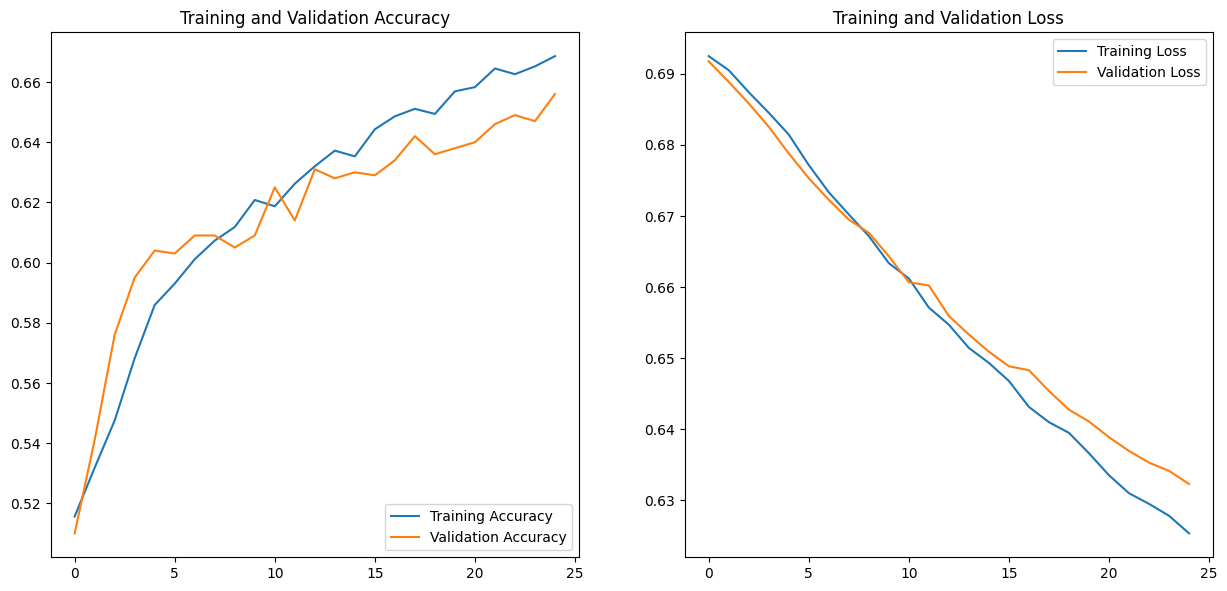

In [48]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']


epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()